## ARCH and GARCH Models

https://github.com/bashtage/arch Package NB

In [3]:
! pip install arch

  Using cached arch-5.2.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (906 kB)
  Using cached property_cached-1.6.4-py2.py3-none-any.whl (7.8 kB)


In [4]:
import arch
from arch import arch_model
from arch.univariate import GARCH
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import sys
import math
from matplotlib.dates import DateFormatter
from scipy.stats import invweibull
from arch.univariate import ARX # autoregressive model on max loss returns, 1 3, 12 lags
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

sys.path.append("/home/jovyan/data_warehouse/")
from dw_src.api.features_api import get_features_df, load_features

### Prep Data

In [31]:
# High Frequency Data
features_to_load = [
    "midprice_mean",
    "traded_price_mean"

]

# Last 2 weeks
end_date = datetime.datetime.now(datetime.timezone.utc)
start_date = end_date - datetime.timedelta(days=30)

# Choose buckketing
time_agg = "60sec" #60sec

high_freq= load_features(
    "ftx", "BTCUSDP", time_agg, start_date, end_date, features_to_load
)
high_freq.to_csv("1Min_BTCUSDP_March23_30.csv")

/opt/conda/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Query complete after 0.50s: 100%|██████████| 3/3 [00:00<00:00,  6.03query/s]                                  
/opt/conda/lib/python3.8/site-packages/google/cloud/bigquery/client.py:444: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(
Downloading: 100%|██████████| 41715/41715 [00:01<00:00, 23711.35rows/s]


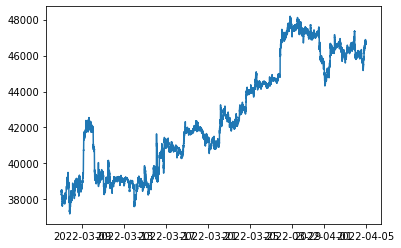

In [32]:
plt.plot(high_freq['midprice_mean'])

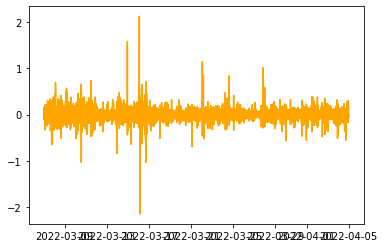

In [33]:
high_freq['return']=100 * high_freq['midprice_mean'].pct_change()
plt.plot(high_freq['return'].dropna(),color='orange')

In [34]:
high_freq=high_freq.dropna()
high_freq

,exchange,symbol,midprice_mean,traded_price_mean,return
timestamp,,,,,
2022-03-07 00:47:00+00:00,ftx,BTCUSDP,38281.071012,38280.348958,0.011480
2022-03-07 00:48:00+00:00,ftx,BTCUSDP,38307.074575,38311.117371,0.067928
2022-03-07 00:49:00+00:00,ftx,BTCUSDP,38277.271777,38279.440860,-0.077800
2022-03-07 00:50:00+00:00,ftx,BTCUSDP,38245.768603,38241.612676,-0.082303
2022-03-07 00:51:00+00:00,ftx,BTCUSDP,38279.947487,38279.437500,0.089366
...,...,...,...,...,...
2022-04-04 23:55:00+00:00,ftx,BTCUSDP,46629.939490,46629.180258,-0.027809
2022-04-04 23:56:00+00:00,ftx,BTCUSDP,46631.468987,46629.814815,0.003280
2022-04-04 23:57:00+00:00,ftx,BTCUSDP,46640.596009,46640.598592,0.019573


In [73]:
def generate_max(series): 
    '''
    Here is largest negative return for  60 minute buckets consisting of 1 min increments
    
    '''
    
    max_values=pd.Series([])
    for i in range(0,math.floor(len(series.values)/60)):  # hourly 
      
        max_elt=min(series[i*60:(i+1)*60])
        
        
        max_values=max_values.append(pd.Series([max_elt],index=[series.index[i*60]])) # index 
 
    
    return -max_values # view losses as positive

In [74]:
max_series=generate_max(high_freq['return'])

<ipython-input-73-979300edec30>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  max_values=pd.Series([])


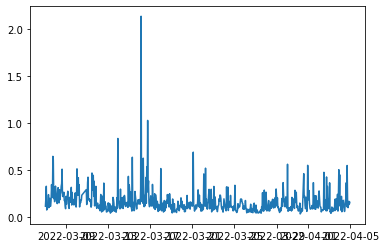

In [75]:
plt.plot(max_series)

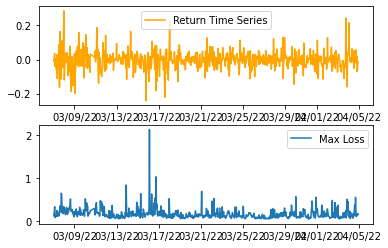

In [76]:
fig,ax = plt.subplots(2,1)


ax[1].plot(max_series, label='Max Loss')
ax[0].plot(-high_freq['return'][::60], label='Return Time Series',color='orange') # negative, sampled every 60 seconds
ax[0].legend()
ax[1].legend()
ax[0].xaxis.set_major_formatter(DateFormatter("%D"))
ax[1].xaxis.set_major_formatter(DateFormatter("%D"))

## Fitting a Frechet / Inverse Weibull Dist 

In [77]:
global_shape,global_loc,global_scale=invweibull.fit(max_series[:450])
global_shape,global_loc,global_scale

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


(3.1146276771813763, -0.05621009323237719, 0.17306807513508604)

No handles with labels found to put in legend.


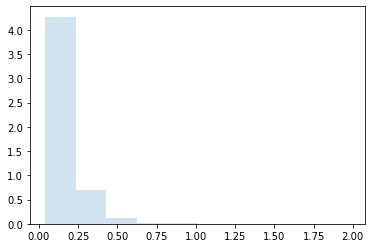

In [78]:
r = invweibull.rvs(global_shape,loc=global_loc,scale=global_scale, size=1000)
plt.hist(r, density=True, histtype='stepfilled', alpha=0.2)
plt.legend(loc='best', frameon=False)
plt.show()

## Empirical Data

No handles with labels found to put in legend.


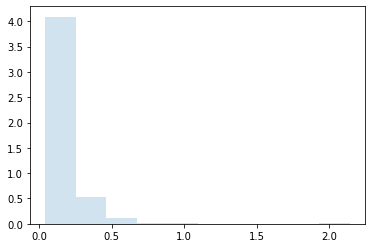

In [79]:
plt.hist(max_series[:450], density=True, histtype='stepfilled', alpha=0.2)
plt.legend(loc='best', frameon=False)
plt.show()

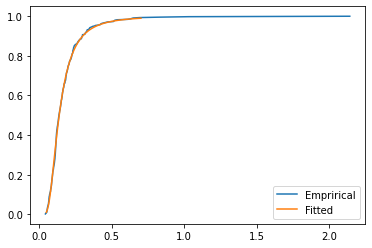

In [80]:
### Comparing Static distributions
ecdf=ECDF(max_series[:450])
plt.plot(ecdf.x,ecdf.y,label='Emprirical')

n=100
x = np.linspace(invweibull.ppf(0.01, global_shape,loc=global_loc,scale=global_scale),
                invweibull.ppf(0.99, global_shape,loc=global_loc,scale=global_scale), n)
frechet_cdf=invweibull.cdf(x,global_shape,loc=global_loc,scale=global_scale)
plt.plot(x,frechet_cdf,label='Fitted')
plt.legend()


**Notes**
- Exhibited is empirical pdf and cdf against the fitted frechet distribution off global trained loc/scale/shape parameters
- This is a static approach, no time varying is incorporated

# Incorporating time varying parameters 

### Train Data ->
- First 450/686 Samples
- Very time intensive do not rerun frequently


In [96]:
k= len(max_series)-450# num samples

time_vary=pd.DataFrame()
time_vary['return']=-high_freq['return'][::60]
time_vary['max_loss']=max_series


shape_vals=pd.Series([global_shape],index=[max_series.index[449]])
loc_vals=pd.Series([global_loc],index=[max_series.index[449]])
scale_vals=pd.Series([global_scale],index=[max_series.index[449]])

i=0
for index,elt in max_series[450:].iteritems(): # sample every 100 elements for consistency 
    
    shape,loc,scale=invweibull.fit(max_series[:450+i],floc=global_loc) # fit all data up until observ, fix location param 
    
    shape_vals=shape_vals.append(pd.Series([shape],index=[index]))
    loc_vals=loc_vals.append(pd.Series([loc],index=[index]))
    scale_vals=scale_vals.append(pd.Series([scale],index=[index]))
    i=i+1
        
time_vary['shape']=shape_vals
time_vary['loc']=loc_vals
time_vary['scale']=scale_vals
time_vary['shape']=time_vary['shape'].bfill()
time_vary['loc']=time_vary['loc'].bfill()
time_vary['scale']=time_vary['scale'].bfill()
time_vary.to_csv('time_vary.csv')

/opt/conda/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


In [97]:
time_vary

,return,max_loss,shape,loc,scale
timestamp,,,,,
2022-03-07 00:47:00+00:00,-0.011480,0.117802,3.114628,-0.05621,0.173068
2022-03-07 01:47:00+00:00,0.018258,0.200802,3.114628,-0.05621,0.173068
2022-03-07 02:47:00+00:00,0.035388,0.329672,3.114628,-0.05621,0.173068
2022-03-07 03:47:00+00:00,-0.040322,0.076803,3.114628,-0.05621,0.173068
2022-03-07 04:47:00+00:00,-0.004237,0.111166,3.114628,-0.05621,0.173068
...,...,...,...,...,...
2022-04-04 19:00:00+00:00,-0.022688,0.101649,3.067256,-0.05621,0.163425
2022-04-04 20:00:00+00:00,0.020142,0.130483,3.070135,-0.05621,0.163396
2022-04-04 21:00:00+00:00,-0.072220,0.169129,3.072116,-0.05621,0.163407


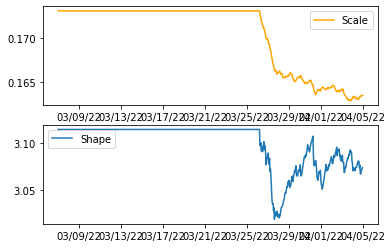

In [98]:
fig,ax = plt.subplots(2,1)


ax[1].plot(time_vary['shape'], label='Shape')
ax[0].plot(time_vary['scale'], label='Scale',color='orange') # negative, sampled every 60 seconds
ax[0].legend()
ax[1].legend()
ax[0].xaxis.set_major_formatter(DateFormatter("%D"))
ax[1].xaxis.set_major_formatter(DateFormatter("%D"))

### Precalibrated data for Time varying parameters

Problems
- Estimating coefficients on our functional form
- Is conditional MLE representative

In [99]:
arc_model=pd.read_csv('time_vary.csv')
arc_model

,timestamp,return,max_loss,shape,loc,scale
0,2022-03-07 00:47:00+00:00,-0.011480,0.117802,3.114628,-0.05621,0.173068
1,2022-03-07 01:47:00+00:00,0.018258,0.200802,3.114628,-0.05621,0.173068
2,2022-03-07 02:47:00+00:00,0.035388,0.329672,3.114628,-0.05621,0.173068
3,2022-03-07 03:47:00+00:00,-0.040322,0.076803,3.114628,-0.05621,0.173068
4,2022-03-07 04:47:00+00:00,-0.004237,0.111166,3.114628,-0.05621,0.173068
...,...,...,...,...,...,...
681,2022-04-04 19:00:00+00:00,-0.022688,0.101649,3.067256,-0.05621,0.163425
682,2022-04-04 20:00:00+00:00,0.020142,0.130483,3.070135,-0.05621,0.163396
683,2022-04-04 21:00:00+00:00,-0.072220,0.169129,3.072116,-0.05621,0.163407
684,2022-04-04 22:00:00+00:00,-0.028075,0.139845,3.072459,-0.05621,0.163454


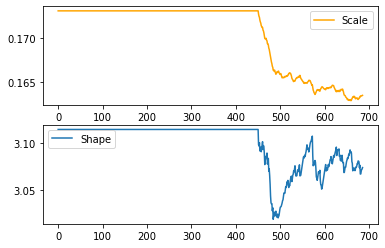

In [100]:
fig,ax = plt.subplots(2,1)


ax[1].plot(arc_model['shape'].values, label='Shape')
ax[0].plot(arc_model['scale'].values, label='Scale',color='orange') # flip returns to view
ax[0].legend()
ax[1].legend()


## Note all of our regressions and comparisons only utilize the test set

In [106]:
exog=-arc_model['max_loss'][449:-1].values 


In [107]:
mod = AutoReg(np.log(arc_model['shape'][450:].values),1,trend='c',exog=np.exp(exog))
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  236
Model:                   AutoReg-X(1)   Log Likelihood                1228.387
Method:               Conditional MLE   S.D. of innovations              0.001
Date:                Wed, 06 Apr 2022   AIC                            -13.258
Time:                        01:03:36   BIC                            -13.199
Sample:                             1   HQIC                           -13.234
                                  236                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0272      0.014      1.903      0.057      -0.001       0.055
y.L1           0.9704      0.013     76.545      0.000       0.946       0.995
x1             0.0068      0.001      6.260      0.0

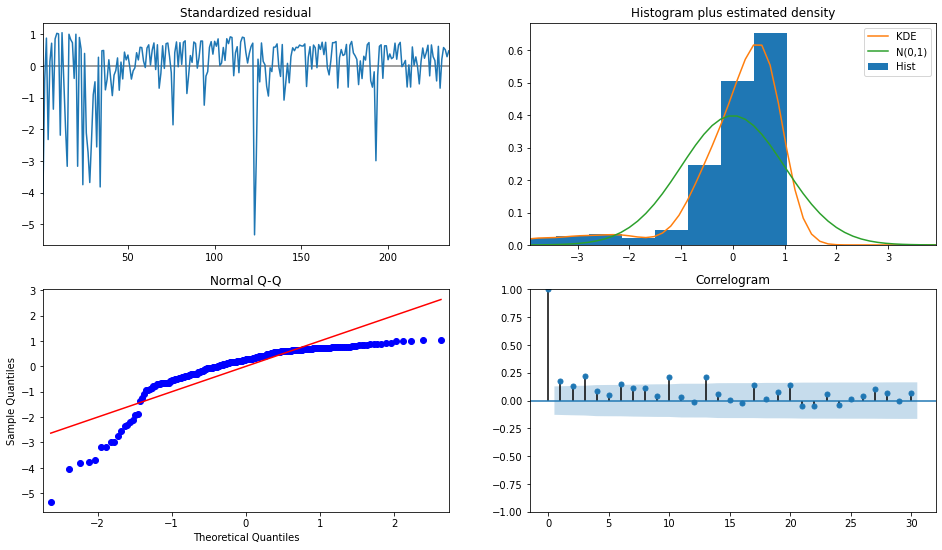

In [108]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

# Standardized residual shows non-explained by model
# Estimated density against N(0,1)
# Correlogram shows acf function 

In [109]:
mod = AutoReg(np.log(arc_model['scale'][450:].values),1,trend='c',exog=np.exp(exog))
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  236
Model:                   AutoReg-X(1)   Log Likelihood                1527.600
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Wed, 06 Apr 2022   AIC                            -15.805
Time:                        01:03:50   BIC                            -15.746
Sample:                             1   HQIC                           -15.781
                                  236                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0185      0.003     -5.312      0.000      -0.025      -0.012
y.L1           0.9864      0.002    523.344      0.000       0.983       0.990
x1            -0.0071      0.000    -22.146      0.0

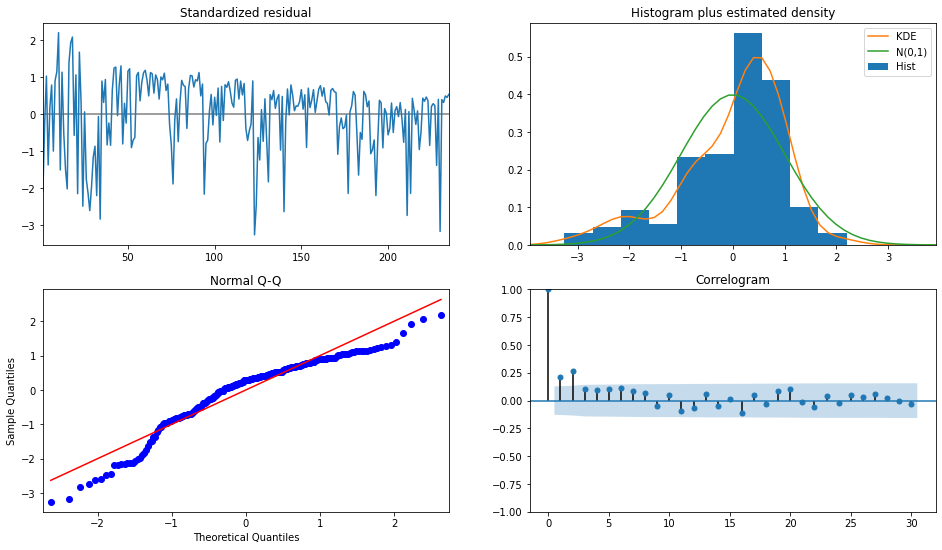

In [110]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

# Standardized residual shows non-explained by model
# Estimated density against N(0,1)
# Correlogram shows acf function 

## CVAR Estiamtion and Analysis

## Scale Parameter comparison to GARCH on Midprice Series

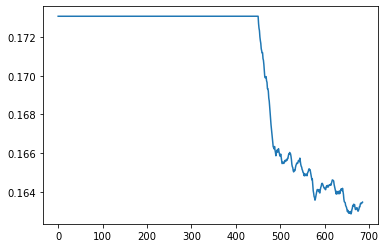

In [111]:
plt.plot(arc_model['scale'])

In [112]:
am = arch_model(arc_model['return'][449:-1],rescale=True)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 156.09913429825951
Iteration:     10,   Func. Count:     63,   Neg. LLF: 156.01379028105492
Optimization terminated successfully    (Exit mode 0)
            Current function value: 156.01379028105492
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -156.014
Distribution:                  Normal   AIC:                           320.028
Method:            Maximum Likelihood   BIC:                           333.883
                                        No. Observations:                  236
Date:                Wed, Apr 06 2022   Df Residuals:                      235
Time:       

In [113]:
res.conditional_volatility

449    0.386751
450    0.517276
451    0.491452
452    0.465363
453    0.441119
         ...   
680    0.419893
681    0.450336
682    0.436540
683    0.424707
684    0.479910
Name: cond_vol, Length: 236, dtype: float64

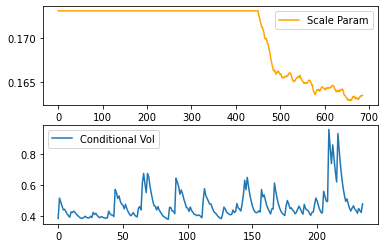

In [114]:
fig,ax = plt.subplots(2,1)


ax[1].plot(res.conditional_volatility.values, label='Conditional Vol')
ax[0].plot(arc_model['scale'].values, label='Scale Param',color='orange') # flip returns to view
ax[0].legend()
ax[1].legend()
